# Accuracy Report
This notebook provides a visual analysis of the extraction accuracy compared to the ground truth across multiple documents.

---

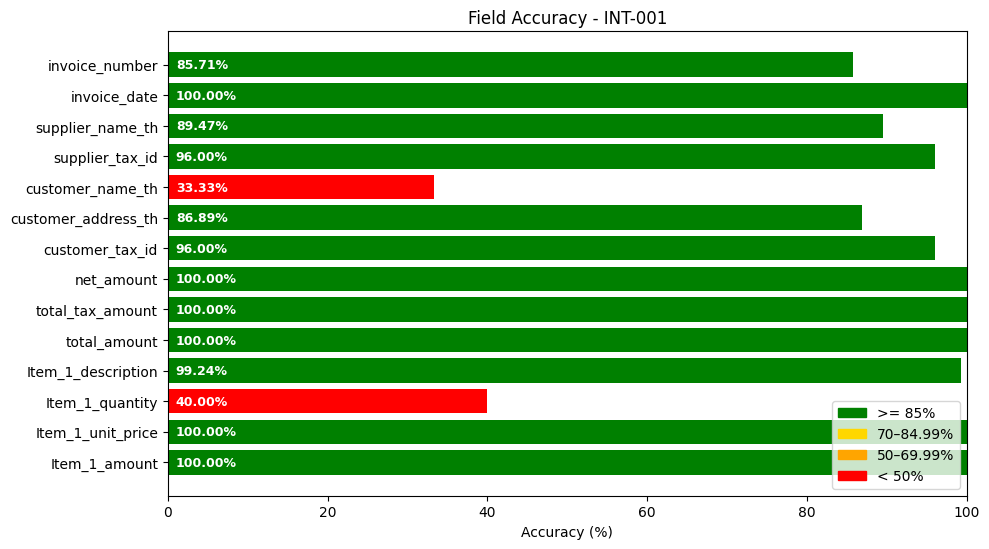

Field,Accuracy,Ground Truth,Result,Category
invoice_number,85.710000,25102400095,2510260095,Header
invoice_date,100.000000,24/10/2025,24/10/2025,Header
supplier_name_th,89.470000,บริษัท อินเทอร์เน็ตประเทศไทย จำกัด (มหาชน),บริษัท อินเทอร์เน็ตประเทศไทย จำกัด,Header
supplier_tax_id,96.000000,0107544000094,010754400094,Header
customer_name_th,33.330000,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บมจ. อินเทอร์เน็ต โซลูชั่นส์ คอร์เปอเรชั่น,Header
customer_address_th,86.890000,เลขที่ 3 อาคาร พร้อมพันธุ์ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน ลาดพร้าว แขวง จอมพล เขต จตุจักร กรุงเทพมหานคร 10900,เลขที่ 3 อาคาร พร้อมพื้นที่ 3 ห้องเลขที่ 1608-1614 ชั้นที่ 16 ซอย ลาดพร้าว 3 ถนน สาทรปราเวศ แขวง ฉัตรชัย เขต จตุจักร กรุงเทพมหานคร 10900,Header
customer_tax_id,96.000000,0105551117714,010551117714,Header
net_amount,100.000000,600.00,600.00,Header
total_tax_amount,100.000000,42.00,42.00,Header
total_amount,100.000000,642.00,642.00,Header


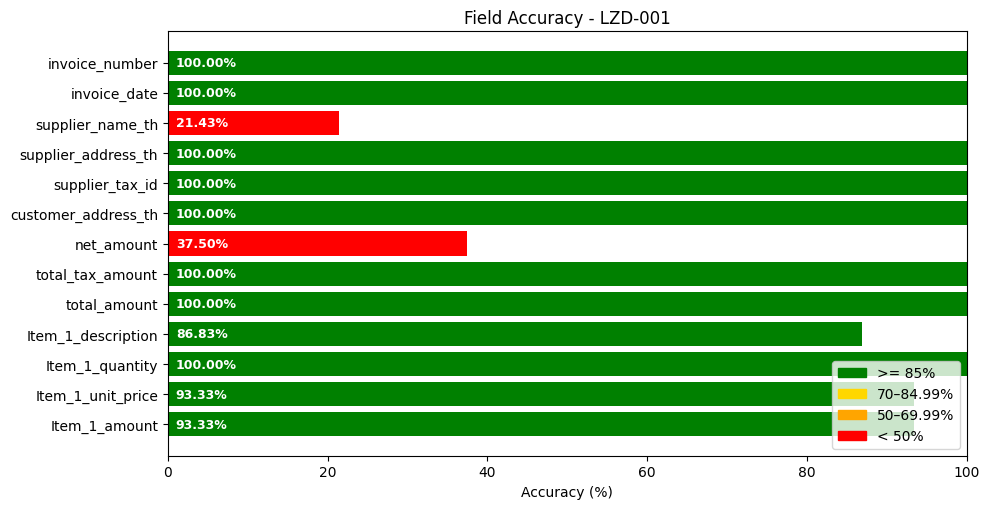

Field,Accuracy,Ground Truth,Result,Category
invoice_number,100.000000,IN0018918431,IN0018918431,Header
invoice_date,100.000000,26/01/2023,26/01/2023,Header
supplier_name_th,21.430000,LAZADA LIMITED,Lazada Limited,Header
supplier_address_th,100.000000,"29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110","29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110",Header
supplier_tax_id,100.000000,0105555040244,0105555040244,Header
customer_address_th,100.000000,"กรุงเทพมหานคร/ Bangkok, 10230","กรุงเทพมหานคร/ Bangkok, 10230",Header
net_amount,37.500000,"1,269.00","1,185.98",Header
total_tax_amount,100.000000,83.02,83.02,Header
total_amount,100.000000,"1,269.00","1,269.00",Header
Item_1_description,86.830000,Certainty ผ้าอ้อมผู้ใหญ่แบบเทป เซอร์เทนตี้ อีซี่เทป Easy Tapeราคาประหยัด ลัง Super Save ไซส์ L 96 ชิ้น,Certainly ฝาอ้อมผู้ใหญ่นแบบแพ็ค เชอร์เทนส์ อีฟี่แทป Easy Taperราคาประหยัด สัง Super Save ไซส์ L 96 ชิ้น,Line Item


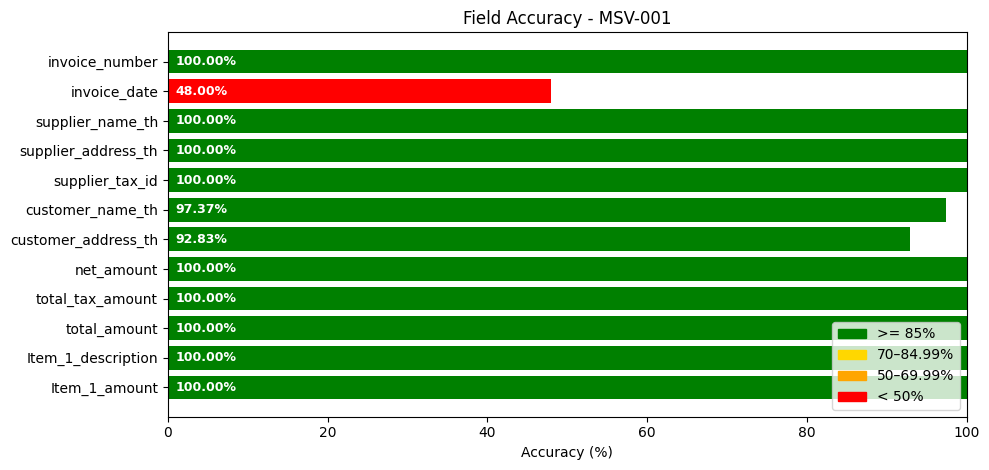

Field,Accuracy,Ground Truth,Result,Category
invoice_number,100.000000,M68/393,M68/393,Header
invoice_date,48.000000,17 กันยายน 2568,17/09/2568,Header
supplier_name_th,100.000000,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด,Header
supplier_address_th,100.000000,"309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250","309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250",Header
supplier_tax_id,100.000000,0105530029573,0105530029573,Header
customer_name_th,97.370000,บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิสต์ จำกัด,บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิตส์ จำกัด,Header
customer_address_th,92.830000,3 อาคารพร้อมพันธุ์ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,ที่อยู่ 3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,Header
net_amount,100.000000,"11,214.95","11,214.95",Header
total_tax_amount,100.000000,785.05,785.05,Header
total_amount,100.000000,"12,000.00","12,000.00",Header


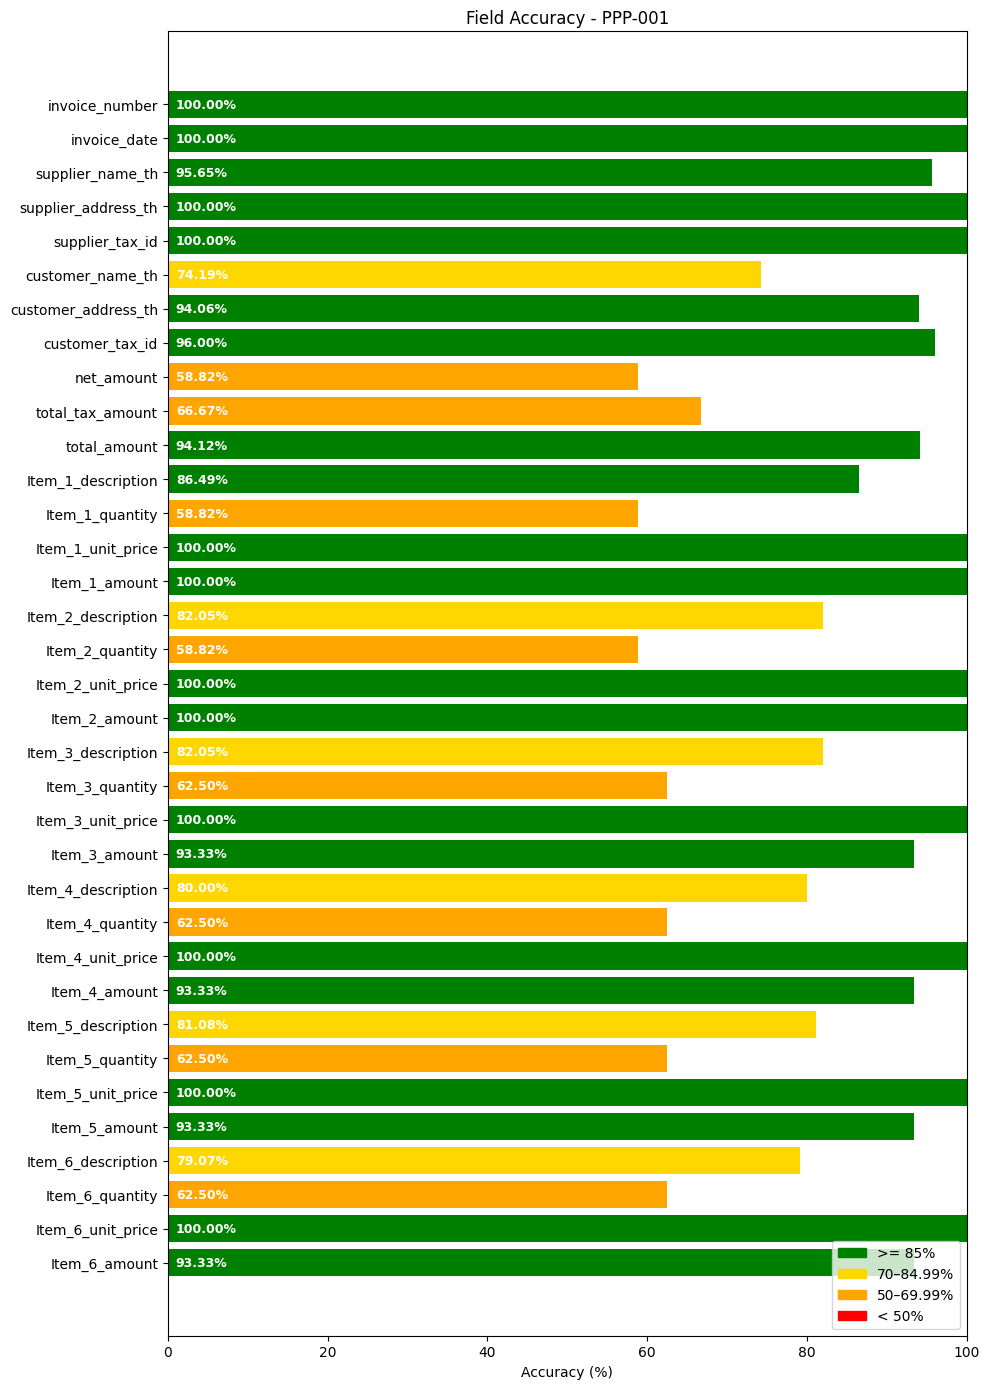

Field,Accuracy,Ground Truth,Result,Category
invoice_number,100.000000,R36810186,R36810186,Header
invoice_date,100.000000,07/10/68,07/10/68,Header
supplier_name_th,95.650000,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูล ประสิทธิ์-ตี จำกัด,Header
supplier_address_th,100.000000,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,Header
supplier_tax_id,100.000000,0105534071621,0105534071621,Header
customer_name_th,74.190000,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บอค. อินโนเวสชั่น เซ็กซ์ตรีมิตส์,Header
customer_address_th,94.060000,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
customer_tax_id,96.000000,0105551117714,010551117714,Header
net_amount,58.820000,"11,985.35",11984.41,Header
total_tax_amount,66.670000,838.97,839.91,Header


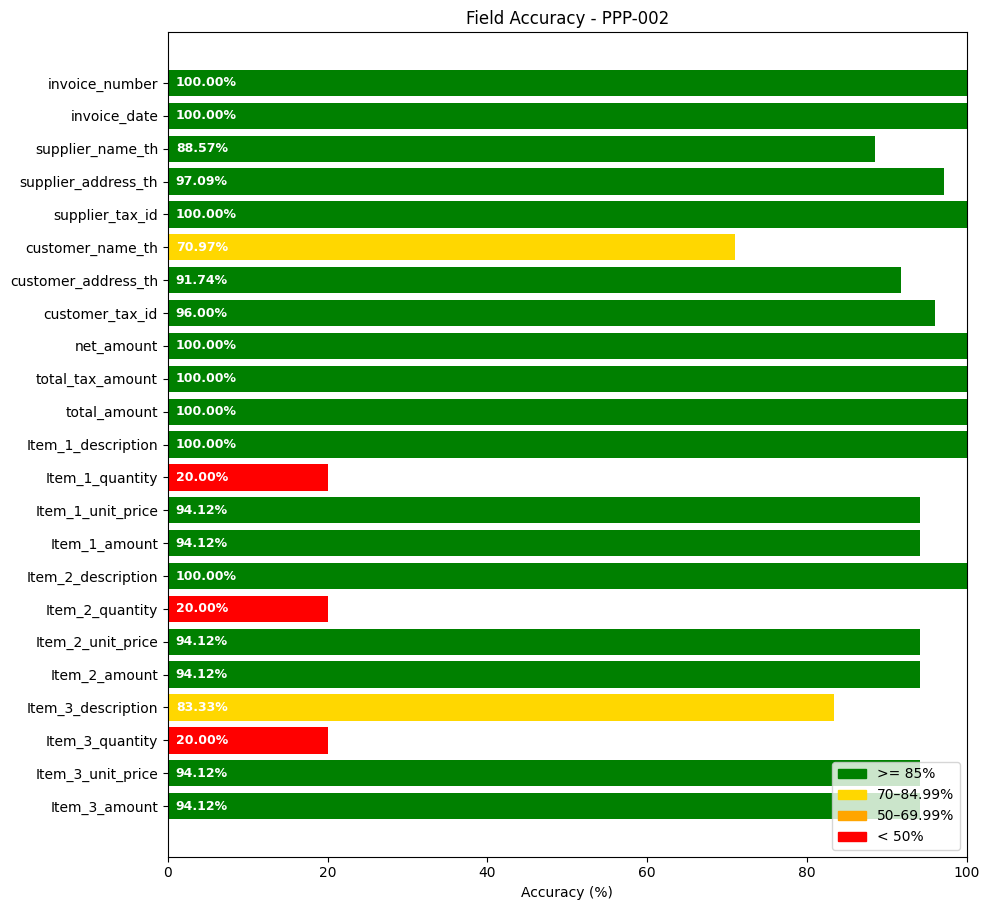

Field,Accuracy,Ground Truth,Result,Category
invoice_number,100.000000,R36810185,R36810185,Header
invoice_date,100.000000,07/10/68,07/10/68,Header
supplier_name_th,88.570000,บริษัท เพิ่มพูล ประสิทธิ์-ตุ๊ จำกัด,บริษัท เพิ่มพูด ประสิทธิ์-คู่ จำกัด,Header
supplier_address_th,97.090000,637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900,"637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ, 10900.",Header
supplier_tax_id,100.000000,0105534071621,0105534071621,Header
customer_name_th,70.970000,บจก. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บมจ. อินโนเวสท์ เอ็กซ์เพรเมียนท์,Header
customer_address_th,91.740000,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว เเขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,อาคารพร้อมพื้นที่ ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900,Header
customer_tax_id,96.000000,0105551117714,010551117714,Header
net_amount,100.000000,"46,700.30","46,700.30",Header
total_tax_amount,100.000000,"3,269.02","3,269.02",Header


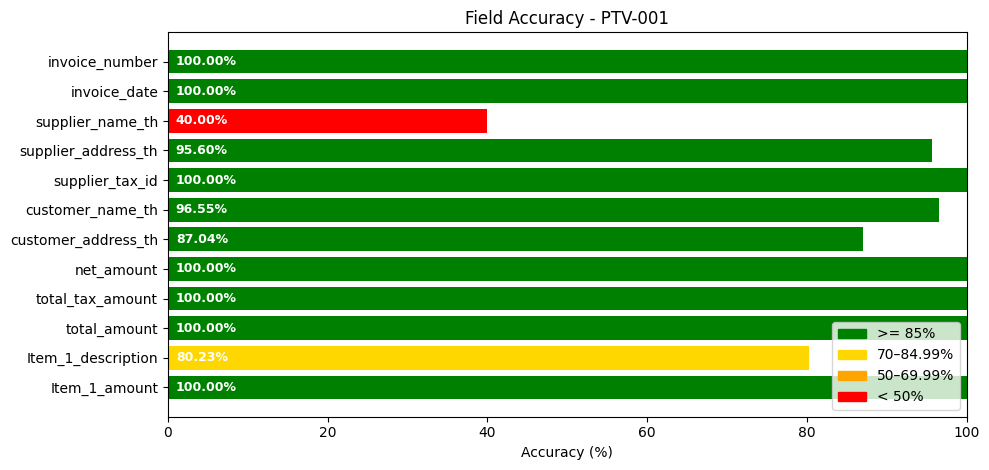

Field,Accuracy,Ground Truth,Result,Category
invoice_number,100.000000,68101365,68101365,Header
invoice_date,100.000000,24/10/2025,24/10/2025,Header
supplier_name_th,40.000000,บริษัท พันธวณิช จำกัด,พันธวณีย์,Header
supplier_address_th,95.600000,1168/94 อาคารลุมพินีทาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,1168/94 อาคารอสมพินิจาวเวอร์ ชั้น 31 ถนนพระราม 4 แขวงทุ่งมหาเมฆ เขตสาทร กรุงเทพมหานคร 10120,Header
supplier_tax_id,100.000000,0105544028248,0105544028248,Header
customer_name_th,96.550000,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิสต์,บจ. อินโนเวทีฟ เอ็กซ์ตรีมิตส์,Header
customer_address_th,87.040000,3 อาคารพร้อมพันธุ์ 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถน นลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900,3 อาคารพร้อมพื้นที่ ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนน ลาภาร้า แขวงแย้มบางพลัด เขตจตุจักร กรุงเทพฯ 10900,Header
net_amount,100.000000,"1,740.00","1,740.00",Header
total_tax_amount,100.000000,121.80,121.80,Header
total_amount,100.000000,"1,861.80","1,861.80",Header


In [62]:
import json
import difflib
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.patches as mpatches

# Global list to store summary results
batch_summary = []

# Configure field weights here (Global weights across documents)
FIELD_WEIGHTS = {
    "invoice_number": 3.0,
    "total_amount": 5.0,
    "net_amount": 3.0,
    "invoice_date": 2.0,
    "total_tax_amount": 2.0,
    "supplier_tax_id": 2.0,
    "customer_tax_id": 2.0,
    "line_items": {
        "description": 0.5,
        "quantity": 1.0,
        "unit_price": 1.5,
        "amount": 2.0
    }
}

def calculate_accuracy(str1, str2):
    str1 = str(str1).strip()
    str2 = str(str2).strip()
    if not str1 and not str2:
        return 100.0
    matcher = difflib.SequenceMatcher(None, str1, str2)
    return round(matcher.ratio() * 100, 2)

def get_comparison_data(gt_path, res_path):
    with open(gt_path, 'r', encoding='utf-8') as f:
        gt = json.load(f)
    with open(res_path, 'r', encoding='utf-8') as f:
        res = json.load(f)

    data = []

    # Header fields
    for key in gt.keys():
        if key == 'line_items':
            continue

        val_gt = gt.get(key)
        val_res = res.get(key, "")

        # Only score if GT exists (non-empty)
        if not val_gt or str(val_gt).strip() == "":
            continue

        acc = calculate_accuracy(val_gt, val_res)
        weight = FIELD_WEIGHTS.get(key, 1.0)
        if isinstance(weight, dict):
            weight = 1.0

        data.append({
            "Field": key,
            "Accuracy": acc,
            "Ground Truth": val_gt,
            "Result": val_res,
            "Category": "Header",
            "Weight": weight
        })

    # Line items
    gt_items = gt.get('line_items', [])
    res_items = res.get('line_items', [])

    for i, item_gt in enumerate(gt_items):
        item_res = res_items[i] if i < len(res_items) else {}
        for k, v_gt in item_gt.items():
            if not v_gt or str(v_gt).strip() == "":
                continue

            v_res = item_res.get(k, "")
            acc = calculate_accuracy(v_gt, v_res)

            line_item_weights = FIELD_WEIGHTS.get('line_items', {})
            weight = line_item_weights.get(k, FIELD_WEIGHTS.get(k, 1.0))

            data.append({
                "Field": f"Item_{i+1}_{k}",
                "Accuracy": acc,
                "Ground Truth": v_gt,
                "Result": v_res,
                "Category": "Line Item",
                "Weight": weight
            })

    return pd.DataFrame(data)

def generate_visual_report(df, filename):
    if df.empty:
        return

    # Weighted accuracy
    doc_points = (df['Accuracy'] * df['Weight']).sum()
    doc_weight = df['Weight'].sum()
    overall_acc = doc_points / doc_weight if doc_weight > 0 else 0

    batch_summary.append({
        "File": filename,
        "Score": overall_acc,
        "WP": doc_points,
        "TW": doc_weight,
        "Fields": len(df)
    })

    # Header output
    display(HTML(
        f"<h1 style='border-bottom: 2px solid #334155; margin-top: 40px;'>Report: {filename}</h1>"
    ))
    display(HTML(
        f"<div style='padding: 15px; background: #f8fafc; border-left: 5px solid #16a34a;'>"
        f"<b style='font-size: 18px;color: black'>Weighted accuracy: {overall_acc:.2f}%</b>"
        f"</div>"
    ))

    # --- Color mapping for bars ---
    # You can adjust thresholds here
    def acc_to_color(acc):
        if acc < 50:
            return "red"
        elif acc < 70:
            return "orange"
        elif acc < 85:
            return "gold"   # more readable than pure yellow
        else:
            return "green"

    colors = [acc_to_color(a) for a in df["Accuracy"]]

    # --- Horizontal bar chart ---
    plt.figure(figsize=(10, max(4, len(df) * 0.4)))
    bars = plt.barh(df['Field'], df['Accuracy'], color=colors)

    plt.title(f'Field Accuracy - {filename}')
    plt.xlabel("Accuracy (%)")
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()

    # --- Add labels on bars ---
    for bar, acc in zip(bars, df["Accuracy"]):
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2

        # Put label slightly right of bar end; keep inside chart bounds
        label_x = min(x + 1.0,1.0)

        plt.text(
            label_x,
            y,
            f"{acc:.2f}%",
            va="center",
            ha="left",
            fontsize=9,
            color="white",
            weight="bold"
        )

    # --- Legend for color buckets ---
    legend_handles = [
        mpatches.Patch(color="green", label=">= 85%"),
        mpatches.Patch(color="gold", label="70–84.99%"),
        mpatches.Patch(color="orange", label="50–69.99%"),
        mpatches.Patch(color="red", label="< 50%")
    ]
    plt.legend(handles=legend_handles, loc="lower right", frameon=True)

    plt.tight_layout()
    plt.show()

    # Table
    display(df[['Field', 'Accuracy', 'Ground Truth', 'Result', 'Category']].style.hide(axis='index'))

# -------------------------
# Batch run configuration
# -------------------------
result_dir = '/Users/pat/Desktop/custom_FM/working/comparison/result/updated_prompt_result/'
gt_dir = '/Users/pat/Desktop/custom_FM/working/comparison/ground_truth/converted/'
batch_summary = []
for res_file in sorted(os.listdir(result_dir)):
    if res_file.startswith("output_") and res_file.endswith(".json"):
        f_id = res_file.replace("output_", "").replace(".json", "")
        gt_p, res_p = os.path.join(gt_dir, f_id+".json"), os.path.join(result_dir, res_file)
        if os.path.exists(gt_p):
            df_res = get_comparison_data(gt_p, res_p)
            generate_visual_report(df_res, f_id)

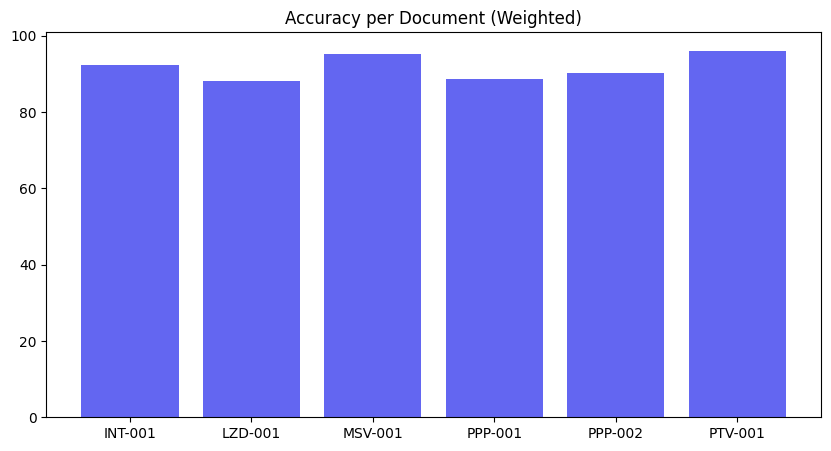

In [63]:
# TOTAL BATCH SUMMARY
if batch_summary:
    summary_df = pd.DataFrame(batch_summary)
    total_weighted_avg = summary_df['WP'].sum() / summary_df['TW'].sum()
    display(HTML(f"""
    <div style='background: #1e293b; color: white; padding: 25px; border-radius: 12px;'>
        <h2 style='margin:0'>Total Global Weighted Accuracy</h2>
        <div style='font-size: 40px; font-weight: bold;'>{total_weighted_avg:.2f}%</div>
    </div>
    """))
    plt.figure(figsize=(10, 5))
    plt.bar(summary_df['File'], summary_df['Score'], color='#6366f1')
    plt.title('Accuracy per Document (Weighted)')
    plt.show()
